In [1]:
import numpy as np
import scipy.optimize
from scipy.special import gamma as gamma_func
from scipy.stats import norm as gaussian, t as student_t

# For example
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data_df = pd.read_csv("DAAA.csv")
Y = data_df["DAAA"].dropna()
Y = np.array(Y).reshape(-1,1)

Y_train = Y[:800]
Y_test = Y[800:]
"hi"

In [9]:
class DAR:
    def __init__(self, p):
        """
        Initialize the DAR class
        """
        self.p = p
        self.params = None
        self.num_params = 1 + 2 * self.p
        self.loglike_val = None

    def t(self, Y):
        T = len(Y)
        self.T = T
        t = np.arange(start=-1, stop=-(T+1), step=-1)
        
        return t
    
    def y(self, Y):
        
        max_lag = self.p 

        Y = np.vstack((np.full((max_lag, Y.shape[1]), np.nan), Y))
        y = lambda t: Y[t,:]
        
        return y

    def parse_params(self, params):
        rho = params[:self.p]
        omega = params[self.p]
        alpha = params[self.p + 1:self.p + 1 + self.p]
        
        params_dict = {
            "rho": rho,
            "omega": omega,
            "alpha": alpha,
            }
        return params_dict

    def condV(self, Y, params = None): # Conditional Variance
        
        omega = params["omega"]
        alpha = params["alpha"]

        y = self.y(Y)
        
        condV = lambda t: omega + sum(alpha[i-1] * y(t-i)**2 for i in range(1, self.p+1))
        return condV
    
    def condE(self, Y, params = None): # Conditional Expecation
        
        rho = params["rho"]
        
        y = self.y(Y)
        condE = lambda t: sum(rho[i-1] * y(t-i) for i in range(1, self.p + 1))
        return condE
    
    def fit(self, Y, dist = "normal"): # Maximum Likelihood Estimation

        t = self.t(Y)

        def MLE(params):
            
            y = self.y(Y)

            if dist == "student-t":
                nu = params[-1]
                params = self.parse_params(params[:-1])
            
            else:
                params = self.parse_params(params)
            
            condE = self.condE(Y, params)
            condV = self.condV(Y, params)

            if dist == "normal":
                l_t = -1/2 * (np.log(condV(t)) + (y(t) - condE(t))**2 / condV(t))
            
            elif dist == "student-t":
                term1 = -0.5 * np.log(condV(t) * (nu - 2) * np.pi)
                term2 = np.log(gamma_func((nu + 1) / 2)) - np.log(gamma_func(nu / 2))
                term3 = -((nu + 1) / 2) * np.log(1 + ((y(t) - condE(t)) ** 2) / (condV(t) * (nu - 2)))
                l_t = term1 + term2 + term3

            else:
                raise ValueError("dist must be 'normal' or 'student-t'")
            
            L_t = np.nansum(l_t)
            return -L_t
        
        # Initialize parameters
        rho_init = [0.0] * self.p
        omega_init = [0.05]
        alpha_init = [0.5] * self.p
        init_params = rho_init + omega_init + alpha_init

        # Set parameter bounds
        rho_bound = [(None, None)] * self.p
        omega_bound = [(0.001, None)]
        alpha_bound = [(0.001, None)] * self.p
        bounds_params = rho_bound + omega_bound + alpha_bound

        # studen-t degrees of freedom
        nu_init = [5]
        nu_bound = [(2.0001, None)]
        
        if dist == "student-t":
            init_params += nu_init
            bounds_params += nu_bound
        
        # opminise the loglikelihood function
        result = scipy.optimize.minimize(MLE, init_params, method='SLSQP', bounds=bounds_params)
        
        # store parameters
        if dist == "student-t":
            self.params = {**self.parse_params(result.x[:-1]), "nu": result.x[-1]}
        else:
            self.params = self.parse_params(result.x)

        # store loglikelihood value
        self.loglike_val = -result.fun
        
        return self

    def std_res(self, Y): # Standardised Residuals
        
        t = self.t(Y)
        y = self.y(Y)

        condE = self.condE(Y, self.params)
        condV = self.condV(Y, self.params)

        z = lambda t: (y(t) - condE(t)) / np.sqrt(condV(t))
        return np.flip(z(t))

    def predict(self, Y): # 1-step ahead forecasted mean
        
        t = self.t(Y)
        
        condE = self.condE(Y, self.params)
        
        return np.flip(np.append(condE(t+1), np.nan)).reshape(-1,1)
    
    def CI(self, Y, alpha_level = 0.05, dist = "normal"): # 1-step ahead forecasted confidence intervals

        t = self.t(Y)
        condE = self.condE(Y, self.params)
        condV = self.condV(Y, self.params)

        if dist == "normal":
            z_val = gaussian.ppf(1 - alpha_level / 2)

        elif dist == "student-t":
            nu = self.params["nu"]
            z_val = student_t.ppf(1 - alpha_level / 2, df = nu) * np.sqrt((nu - 2) / nu)
        
        else:
            raise ValueError("dist must be 'normal' or 'student-t'")
        

        CI = lambda t: np.column_stack((condE(t) + z_val * np.sqrt(condV(t)), 
                                        condE(t) - z_val * np.sqrt(condV(t))
                                        ))
        
        return np.vstack((np.full((1, 2), np.nan), np.flip(CI(t+1))))

In [11]:
model = DAR(p = 2)
model.fit(Y_train)


In [13]:
dist = "student-t"

model = DAR(p = 2)
model.fit(Y_train, dist = dist)
CI = model.CI(Y_test, dist = dist)
fcast = model.predict(Y_test)
model.params

{'rho': array([0.99267674, 0.00766694]),
 'omega': 0.005999193892047455,
 'alpha': array([0.05012422, 0.05009782]),
 'nu': 2.3727247894215426}

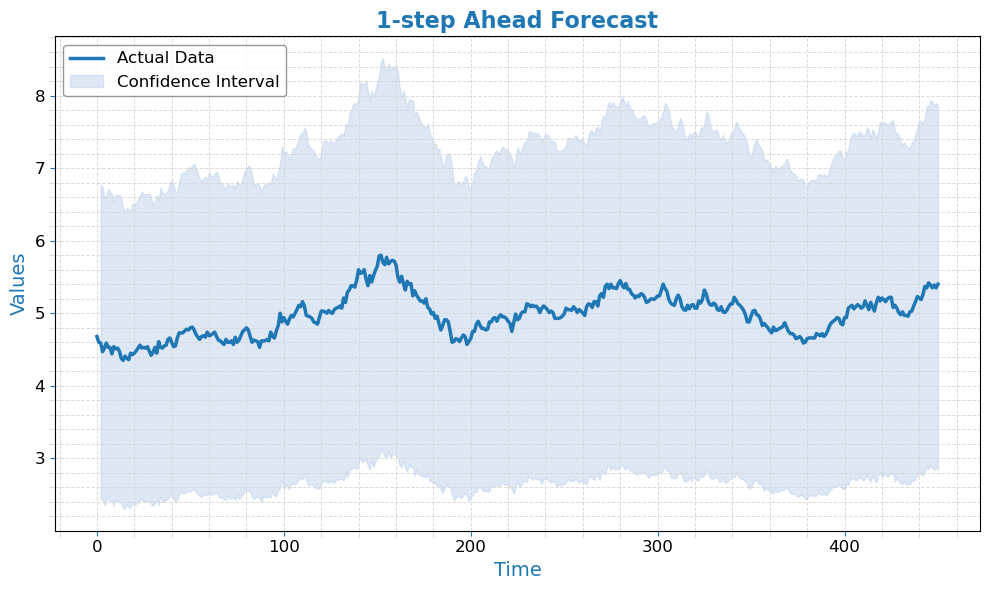

In [15]:
time = np.arange(len(Y_test))
lower_bound, upper_bound = CI[:-1, 0], CI[:-1, 1]

# Define colors
actual_color = '#1f77b4'  # Blue for actual data
ci_fill_color = '#aec7e8'  # Light blue for confidence interval fill
grid_color = '#d3d3d3'  # Light grey for gridlines

# Create the time series plot
plt.figure(figsize=(10, 6))  # Adjust figure size for better clarity

# Plot the actual data
plt.plot(time, Y_test, label='Actual Data', linestyle='-', linewidth=2.5, color=actual_color)

# Plot the confidence interval
plt.fill_between(time, lower_bound, upper_bound, color=ci_fill_color, alpha=0.4, label='Confidence Interval')

# Add labels, title, and legend
plt.title('1-step Ahead Forecast', fontsize=16, fontweight='bold', color=actual_color)
plt.xlabel('Time', fontsize=14, color=actual_color)
plt.ylabel('Values', fontsize=14, color=actual_color)

# Enhance the legend
plt.legend(fontsize=12, loc='upper left', frameon=True, edgecolor='grey')

# Customize gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, color=grid_color, alpha=0.8)

# Add minor ticks for better granularity
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12, color=actual_color)
plt.tick_params(axis='both', which='minor', color=grid_color, length=4)

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()

# Strict Stationarity

In [16]:
from numpy.linalg import eigvals

def spectral_radius(matrix):
    return max(abs(eigvals(matrix)))

In [17]:
p = 2
nu = model.params["nu"]
T = 100000

eta = student_t.rvs(df=nu, size=(p, T)) * np.sqrt((nu - 2) / nu)

rho_array = model.params["rho"].reshape(-1,1)
alpha_array = model.params["alpha"].reshape(-1,1)

# Upper Row
upper_row = (rho_array + np.sqrt(alpha_array) * eta).T

# Lower Rows
bottom_rows = np.hstack((np.eye(p - 1), np.zeros((p - 1, 1))))

# Companion Matrix
A = np.array([np.vstack((row, bottom_rows)) for row in upper_row])

In [18]:
A.shape

(100000, 2, 2)

In [66]:
def strict_statio(A):
    
    """
    Approksimate the top Lyapounov exponent of the companion matrix A
    """

    T, p, _ = A.shape
    log_sum = 0.0
    cumulative_matrix = np.eye(p) # Init with the identity matrix

    for t in range(T):
        cumulative_matrix = np.dot(cumulative_matrix, A[t]) # Multiply the current matrix with the cumulative product
        
        norm_val = np.linalg.norm(cumulative_matrix, ord = 'fro') # Compute the norm of the cumulative product (scaled to avoid overflow)
        
        if norm_val > 0:
            
            log_sum += np.log(norm_val) # Accumulate the log of the norm
            
            cumulative_matrix /= norm_val # Normalize the cumulative matrix to prevent overflow
        else:
            return float('-inf') # Numerical instability or invalid matrix product
            
    return log_sum / T

In [67]:
strict_statio(A)

-0.02873955487837407

In [60]:
A_kron = np.array([np.kron(subarray, subarray) for subarray in A])
result = np.sum(A_kron, axis=0) / T
result

array([[1.02669097, 0.00820378, 0.00820378, 0.05800998],
       [0.99322746, 0.        , 0.00856187, 0.        ],
       [0.99322746, 0.00856187, 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ]])

In [70]:
import torch
torch.set_printoptions(precision=8)
def kron_power(A, n):
    
    A = torch.from_numpy(A).to(dtype = torch.float64)
    results = []

    for matrix in A:
        
        result = matrix
        for _ in range(n - 1):
            result = torch.kron(result, matrix)
        results.append(result)

    kronekcer_power = torch.stack(results)

    return kronekcer_power.cpu().numpy()

In [71]:
A_kron = kron_power(A,2)
np.sum(A_kron, axis=0) / T

array([[1.02669097, 0.00820378, 0.00820378, 0.05800998],
       [0.99322746, 0.        , 0.00856187, 0.        ],
       [0.99322746, 0.00856187, 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ]])

In [72]:
np.average(A_kron, axis=0)

array([[1.02669097, 0.00820378, 0.00820378, 0.05800998],
       [0.99322746, 0.        , 0.00856187, 0.        ],
       [0.99322746, 0.00856187, 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ]])

In [83]:
import torch
torch.set_printoptions(precision=8)

class STATIO:
    def __init__(self, dist, rho, alpha, nu):
        """
        Dummy
        """

        self.rho = rho
        self.alpha = alpha
        self.p = max(len(rho), len(alpha))
        self.nu = nu
        self.dist = dist
    
    def companion_matrix(self, T_sim = 100000): ## Reformulate the model on companion matrix form ##
        
        rho = self.rho.reshape(-1,1)
        alpha = self.alpha.reshape(-1,1)
        nu = self.nu

        if self.dist == "student-t":
            eta = student_t.rvs(df = nu, size=(p, T_sim)) * np.sqrt((nu - 2) / nu)
        else:
            eta = gaussian.rvs(loc = 0, scale = 1, size=(p, T_sim))

        upper_row = (rho + np.sqrt(alpha) * eta).T
        bottom_rows = np.hstack((np.eye(p - 1), np.zeros((p - 1, 1))))
        A = np.array([np.vstack((row, bottom_rows)) for row in upper_row])

        return A
    
    def kron_power(A, n): ## nth Kronecker power of the componaion matrix ##
        
        A = torch.from_numpy(A).to(dtype = torch.float64)
        
        results = []
        for matrix in A:
            
            result = matrix
            for _ in range(n - 1):
                result = torch.kron(result, matrix)
            results.append(result)

        kronekcer_power = torch.stack(results)

        return kronekcer_power.cpu().numpy()
    
    def strict_statio(self): ## Approksimate the top Lyapounov exponent of the companion matrix ##
        
        A = self.companion_matrix()
        T, p, _ = A.shape
        log_sum = 0.0
        cumulative_matrix = np.eye(p) # Init with the identity matrix

        for t in range(T):
            
            cumulative_matrix = np.dot(cumulative_matrix, A[t]) # Multiply the current matrix with the cumulative product
            norm_val = np.linalg.norm(cumulative_matrix, ord = 'fro') # Compute the norm of the cumulative product (scaled to avoid overflow)
            
            if norm_val > 0:
                
                log_sum += np.log(norm_val) # Accumulate the log of the norm
                cumulative_matrix /= norm_val # Normalize the cumulative matrix to prevent overflow
            else:
                
                return float('-inf') # Numerical instability or invalid matrix product
            
        return log_sum / T
    
    def weak_statio(self): ## Compute the spectral radius of the expected value of the second order Kronecker power ##
        
        A = self.companion_matrix()
        A_kron2= kron_power(A,2)
        A_kron2_expected = np.average(A_kron2, axis=0)
        spectral_radius = max(abs(eigvals(A_kron2_expected)))

        return spectral_radius
    


In [92]:
nu = model.params["nu"]
rho = model.params["rho"]
alpha = model.params["alpha"]


2

# DAR model v3 

In [1040]:
import numpy as np
import scipy.optimize
from scipy.special import loggamma
from scipy.stats import norm as gaussian, t as student_t
import numpy as np
from numpy.linalg import eigvals
import torch
torch.set_printoptions(precision=8)


class ParamTracker:
    def __init__(self, params):
        self.params = params
        self.accessed_keys = set()

    def __getitem__(self, key):
        self.accessed_keys.add(key)
        
        return self.params[key]["init"]

    def get_keys(self):
        return self.accessed_keys

class DAR:
    def __init__(self, p = 1, dist = "gaussian"):
        
        self.p = p
        if not isinstance(p, int) or p <= 0:
            raise ValueError("'p' must be a strictly positive integer.")
        
        self.dist = dist
        if dist not in ["student-t", "gaussian"]:
            raise ValueError("'dist' must be either 'student-t' or 'gaussian'.")
        
        self.params = {
            "rho": {"init": np.array([0.2] * p), "bound": [(None, None)] * p},
            "alpha": {"init": np.array([0.5] * p), "bound": [(0.001, None)] * p},
            "omega": {"init": np.array([0.5]), "bound": [(0.001, None)]},
            "nu": {"init": np.array([5]), "bound": [(2.001, None)]},
            }
        
        self.T_sim = 100000
        self.max_lag = p
    
    def __repr__(self):
        """
        Returns a string representation of the DAR model.
        """
        return f"DAR({self.p}) model assuming {self.dist} errors"
    
    def t(self, Y):
        t = np.arange(start = -1, stop = -(len(Y) + 1), step = -1)
        return t
    
    def y(self, Y):
        Y = np.vstack((np.full((self.max_lag, Y.shape[1]), np.nan), Y))
        y = lambda t: Y[t,:]
        return y
    
    def parse_params(self, flat_params):
        params = self.params
        param_sizes = {key: params[key]["init"].size for key in self.param_names}
        offsets = np.cumsum([0] + list(param_sizes.values())[:-1])
        return {
            key: flat_params[offsets[i]: offsets[i] + size].reshape(params[key]["init"].shape)
            for i, (key, size) in enumerate(param_sizes.items())
            }
    
    def condE(self, Y, params):
        rho = params["rho"]
        y = self.y(Y)
        condE = lambda t: sum(rho[i-1] * y(t-i) for i in range(1, self.p + 1))
        return condE
    
    def condV(self, Y, params):
        omega = params["omega"]
        alpha = params["alpha"]
        y = self.y(Y)
        condV = lambda t: omega + sum(alpha[i-1] * y(t-i)**2 for i in range(1, self.p+1))
        return condV
    
    def fit(self, Y):

        def log_likelihood(params):
            t, y = self.t(Y), self.y(Y)
            condE, condV = self.condE(Y, params), self.condV(Y, params)

            if self.dist == "student-t":
                nu = params["nu"]
                l_t = -1/2 * np.log(condV(t)) + loggamma((nu + 1)/2) - loggamma(nu/2) -((nu + 1)/2) * np.log(1 + (y(t) - condE(t))**2 / (condV(t) * (nu - 2)))
            else:
                l_t = -1/2 * (np.log(condV(t)) + (y(t) - condE(t))**2 / condV(t))
            return -np.nansum(l_t)
                
        tracker = ParamTracker(self.params)
        self.param_names = (log_likelihood(tracker), tracker)[1].get_keys()
        
        results = scipy.optimize.minimize(
            lambda params: log_likelihood(self.parse_params(params)),
            np.concatenate([self.params[key]['init'].ravel() for key in self.param_names]),
            method = "SLSQP",
            bounds = np.concatenate([self.params[key]['bound'] for key in self.param_names]),
            )
        
        self.params = self.parse_params(results.x)
        
    def companion_matrix(self):
        T_sim = self.T_sim
        rho   = self.params['rho'].reshape(-1, 1)
        alpha = self.params['alpha'].reshape(-1, 1)
        p = self.p

        if self.dist == "student-t":
            nu = self.params["nu"]
            eta = student_t.rvs(df = nu, size = (p, T_sim)) * np.sqrt((nu - 2) / nu)
        else:
            eta = gaussian.rvs(loc = 0, scale=1, size=(p, T_sim))
        
        upper_row = (rho + np.sqrt(alpha) * eta).T
        bottom_rows = np.hstack((np.eye(p - 1), np.zeros((p - 1, 1))))
        A = np.array([np.vstack((row, bottom_rows)) for row in upper_row])
        return A
    
    def kron_power(self, A, n):
        A = torch.from_numpy(A).to(dtype = torch.float64)
        
        results = []
        for matrix in A:    
            result = matrix
            for _ in range(n - 1):
                result = torch.kron(result, matrix)
            results.append(result)
        
        kronekcer_power = torch.stack(results)
        return kronekcer_power.cpu().numpy()
    
    def strict_statio(self):
        A = self.companion_matrix()
        T, p, _ = A.shape

        log_sum = 0.0
        cumulative_matrix = np.eye(p)
        for t in range(T):
            cumulative_matrix = np.dot(cumulative_matrix, A[t])
            norm_val = np.linalg.norm(cumulative_matrix, ord = 'fro')
            if norm_val > 0:
                log_sum += np.log(norm_val)
                cumulative_matrix /= norm_val
            else:
                return float('-inf')
        return log_sum / T
    
    def weak_statio(self):
        A = self.companion_matrix()

        A_kron2= self.kron_power(A,2)
        A_kron2_expected = np.average(A_kron2, axis = 0)
        spectral_radius = max(abs(eigvals(A_kron2_expected)))
        return spectral_radius
    
    def statio(self, T_sim = 100000):
        
        self.T_sim = T_sim
        
        stationarity_dict = {
            "strictly": {"stationary": self.strict_statio() < 0, "top Lyapunov exponent": self.strict_statio()},
            "weakly": {"stationary": self.weak_statio() < 1, "spectral radius of the expected Kronecker product of the companion matrix": self.weak_statio()}
            }
        return stationarity_dict

    def std_res(self, Y):        
        t, y = self.t(Y), self.y(Y)
        condE = self.condE(Y, self.params)
        condV = self.condV(Y, self.params)

        z = lambda t: (y(t) - condE(t)) / np.sqrt(condV(t))
        return np.flip(z(t))

    def predict(self, Y):
        t = self.t(Y)
        condE = self.condE(Y, self.params)

        return np.flip(np.append(condE(t+1), np.nan)).reshape(-1,1) 
    
    def predict_CI(self, Y, alpha_level = 0.05):
        t = self.t(Y)
        condE = self.condE(Y, self.params)
        condV = self.condV(Y, self.params)

        if self.dist == "student-t":
            nu = self.params["nu"]
            z = student_t.ppf(1 - alpha_level / 2, df = nu) * np.sqrt((nu - 2) / nu)
        else:
            z = gaussian.ppf(1 - alpha_level / 2)

        CI = lambda t: np.column_stack((condE(t) + z * np.sqrt(condV(t)), 
                                        condE(t) - z * np.sqrt(condV(t))
                                        ))
        
        return np.vstack((np.full((1, 2), np.nan), np.flip(CI(t+1))))


In [ ]:
self1 = DAR(3, dist = "student-t")
self1.fit(Y)

In [733]:
# GOOOOOOOOD!!!!!!!!!!!!!!!!

class ParamTracker:
    def __init__(self, params):
        self.params = params
        self.accessed_keys = set()

    def __getitem__(self, key):
        self.accessed_keys.add(key)
        # Return "init" as a list
        return self.params[key]["init"]

    def get_keys(self):
        return self.accessed_keys


def test_func(params):
    rho = params['rho']
    return rho * 2

# Define parameters
p, d = 2, 2
params = {
    "rho": {"init": np.array([0.2] * p), "bound": [(-1, 1)] * p},
    "alpha": {"init": np.array([0.5] * p), "bound": [(-1, 1)] * p},
    "gamma": {"init": np.full((p, d), 0.5), "bound": [(-1, 1)] * (p * d)}
    }

# Define log-likelihood function
def log_likelihood(params):
    alpha = params["alpha"]
    rho = test_func(params)
    #gamma = params["gamma"]
    #return np.sum(rho ** 2 + alpha ** 2 + gamma ** 2)
    return np.sum(rho ** 2 + alpha ** 2)
    

tracker = ParamTracker(params)
param_names = list((log_likelihood(tracker), tracker)[1].get_keys())


# Define reconstruct_params function
def parse_params(flat_params):
    param_sizes = {key: params[key]["init"].size for key in param_names}
    offsets = np.cumsum([0] + list(param_sizes.values())[:-1])
    return {
        key: flat_params[offsets[i]: offsets[i] + size].reshape(params[key]["init"].shape)
        for i, (key, size) in enumerate(param_sizes.items())
        }


results = scipy.optimize.minimize(
    lambda params: log_likelihood(parse_params(params)),
    np.concatenate([params[key]['init'].ravel() for key in param_names]),
    method = "SLSQP",
    bounds = np.concatenate([params[key]['bound'] for key in param_names]),
    )

optimized_params = parse_params(results.x)
for key in param_names:
    params[key]["init"] = optimized_params[key]


optimized_params


{'rho': array([-5.45587545e-09, -5.45587543e-09]),
 'alpha': array([-4.77241463e-09, -4.77241474e-09])}

In [ ]:
# Do not delete

params = {
    "rho": {"init": np.array([0.2] * p), "bound": [(-1, 1)] * p},
    "alpha": {"init": np.array([0.5] * p), "bound": [(-1, 1)] * p},
    "gamma": {"init": np.full((p, d), 0.5), "bound": [(-1, 1)] * (p * d)}
    }


 


def __repr__(self):
        """
        Returns a string representation of the DAR model.
        """
        return f"DAR({self.p}) model with {self.dist} innovations"
    

    
def condV(self, Y, params):
        
        omega = params["omega"]
        alpha = params["alpha"]

        y = self.y(Y)
        
        condV = lambda t: omega + sum(alpha[i-1] * y(t-i)**2 for i in range(1, self.p+1))
        return condV

def fit(self):

        def log_likelihood(params):

            t = self.t(Y)
            y = self.y(Y)
            condE = self.condE(Y, params)
            condV = self.condV(Y, params)

            l_t = -1/2 * (np.log(condV(t)) + (y(t) - condE(t))**2 / condV(t))
            L_t = np.nansum(l_t)
            return -L_t
        
        # Initialize parameters
        rho_init = [0.0] * self.p
        omega_init = [0.05]
        alpha_init = [0.5] * self.p
        init_params = rho_init + omega_init + alpha_init

        # Set parameter bounds
        rho_bound = [(None, None)] * self.p
        omega_bound = [(0.001, None)]
        alpha_bound = [(0.001, None)] * self.p
        bounds_params = rho_bound + omega_bound + alpha_bound

        # optimise the loglikelihood function
        result = scipy.optimize.minimize(log_likelihood, init_params, method='SLSQP', bounds = bounds_params)

2